In [10]:
is_colab = False
import sys
if is_colab:
    try:
        import torch  
        print('Module torch was installed')
    except ImportError:    
        print("Installinng torch 1.8.1")
        !pip install -q torch==1.8.1
    try:
        import torchvision  
        print('Module torchvision was installed')
    except ImportError:    
        print("Installinng torchvision 0.4.0")
        !pip install -q torchvision==0.4.0
    
    try:
        import qiskit  
        print('Module qiskit was installed')
    except ImportError:    
        print("Installinng qiskit 0.14.0")
        !pip install -q qiskit==0.14.0

    !wget --no-check-certificate 'https://drive.google.com/uc?id=11XfMLqwFZnqoYb3qoUos97YfSLd9RAO7' -O codes.tar.gz
    !tar zxvf /content/codes.tar.gz

    sys.path.append('/content/libs')



import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


import sys
import functools
from qiskit import  QuantumCircuit, ClassicalRegister
from qiskit import Aer, execute
import math

from circuit.lib_qiskit_commons import *
from circuit.lib_circuit_linner_square import *
from training.lib_dataloader import *

import qiskit

print = functools.partial(print, flush=True)


In [11]:
#define parameter
input_data_num =20
init_weight = torch.tensor([[-1,1,1,1]],dtype=torch.double)
threshold = 0.2
def binary(input):
    output = input.new(input.size())
    output[input >= threshold] = 1
    output[input < threshold] = 0
    return output

#get correct result with no error
input_data = torch.rand(input_data_num,4,dtype=torch.double)
input_data_quantum_matrix = []
for i in range(input_data_num):
    quantum_matrix =to_quantum_matrix(input_data[i])
    n1_q_gates,n1_idx =ULayerCircuit.extract_from_weight(init_weight[0])
    input_data_quantum_matrix.append(quantum_matrix[:, 0].view(-1))

input_data_quantum_matrix = torch.stack(input_data_quantum_matrix)
# print(input_data_quantum_matrix.t()[0:4].t())
# print(input_data_quantum_matrix)
correct_result =torch.mm(init_weight,input_data_quantum_matrix.t())
correct_result = correct_result*correct_result/4
# print(correct_result)
correct_result_binary = binary(correct_result.t())
print(correct_result_binary.t())


tensor([[1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
         1., 0.]], dtype=torch.float64)


correct result  : tensor(1., dtype=torch.float64)
Result : 0.0


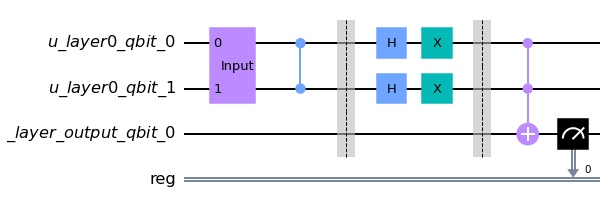

In [12]:
######################################################
#example of u-layer
i = 0
#transform input_data into u-Mat
quantum_matrix =to_quantum_matrix(input_data[i])

#generate u-layer
#define your input and output number
u_layer = ULayerCircuit(2,1) 
#init circuit
circuit = QuantumCircuit()
#add input qubit to your circuit
inps = u_layer.add_input_qubits(circuit)

#add output qubit to your circuit
u_layer_out_qubits = u_layer.add_out_qubits(circuit)

#add ulayer to your circuit
u_layer.forward(circuit,init_weight,inps,u_layer_out_qubits,quantum_matrix)

#measure
c_reg = ClassicalRegister(1,"reg")
circuit.add_register(c_reg)
circuit.measure(u_layer_out_qubits[0],c_reg[0])

#get the result
qc_shots=8192
opt_counts = fire_ibmq(circuit,qc_shots,True)
(opt_mycount,bits) = analyze(opt_counts)
prob = float(opt_mycount[bits])/qc_shots

print("correct result  :",correct_result_binary[i][0])
print("Result :",prob)
circuit.draw('mpl',fold=50)


######################################################



In [13]:
circuit_result = []
for i in range(input_data_num):
    quantum_matrix =to_quantum_matrix(input_data[i])
    
    #generate u-layer
    #define your input and output number
    u_layer = ULayerCircuit(2,1) 
    #init circuit
    circuit = QuantumCircuit()
    #add input qubit to your circuit
    inps = u_layer.add_input_qubits(circuit)
    
    #add output qubit to your circuit
    u_layer_out_qubits = u_layer.add_out_qubits(circuit)
    
    #add ulayer to your circuit
    u_layer.forward(circuit,init_weight,inps,u_layer_out_qubits,quantum_matrix)
    
    #measure
    c_reg = ClassicalRegister(1,"reg")
    circuit.add_register(c_reg)
    circuit.measure(u_layer_out_qubits[0],c_reg[0])
    
    #get the result
    qc_shots=100000
    opt_counts = fire_ibmq(circuit,qc_shots,True)
    opt_class_prob = []
    (opt_mycount,bits) = analyze(opt_counts)
    for b in range(bits):
        opt_class_prob.append(float(opt_mycount[b])/qc_shots)
    if opt_class_prob[0] >= threshold :
        circuit_result.append(1)
    else:
        circuit_result.append(0)

circuit_result_tensor = torch.tensor(circuit_result,dtype=torch.double)

print("correct_result_binary:",correct_result_binary.t())
print("circuit_result_tensor:",circuit_result_tensor)

CircuitError: 'The amount of qubit(4)/clbit(0) arguments does not match the gate expectation (2).'